# Multiscale Migration Model

This notebook implements our model using `numpy`, `haversine`, and `pandas` (with `xlrd`). It has been tested to run on Python 3.6. To start, import the required libraries.

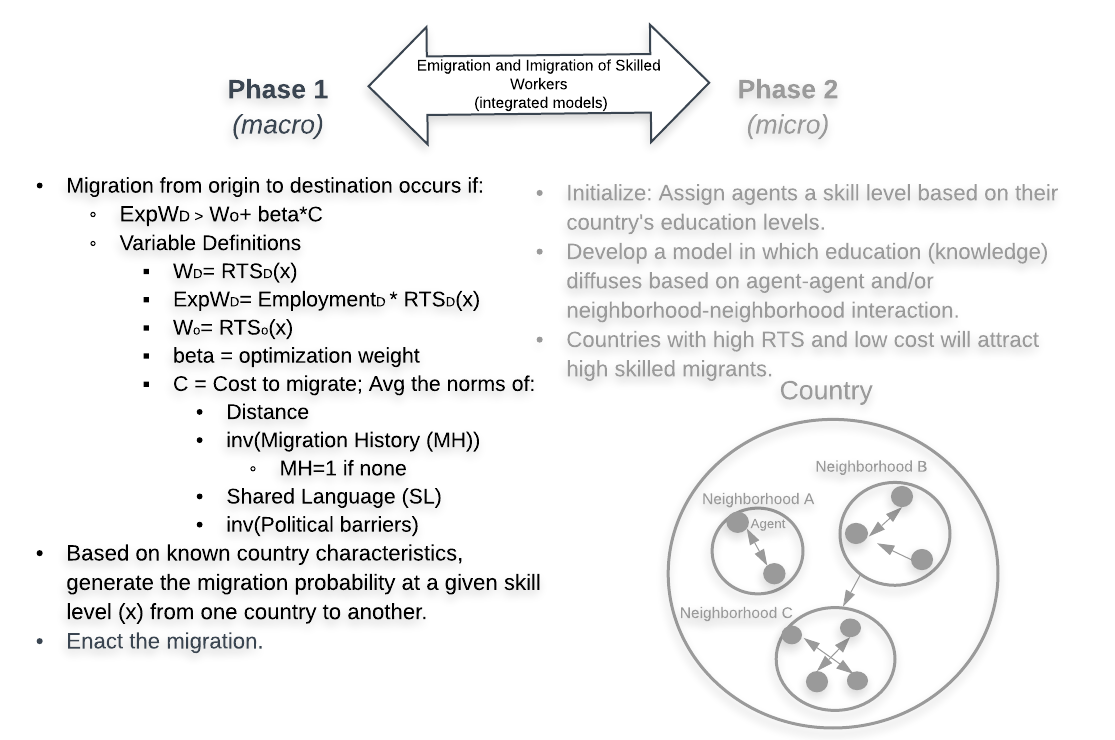

### TODO

+ Verify that the code matches the model as described in the paper.
+ Add visulazations for what countries are represented and perhaps for that matrices between countries.

In [ ]:
import numpy as np
import pandas as pd
from math import e
from haversine import haversine

There are a number of datasets used in this model. They can all be found in the `/data` subdirectory.

In [ ]:
%ls data

The following shortcut functions helps locate these data files easily.

In [ ]:
def file_path(name):
    """
    Shortcut function to get the relative path to the directory
    which contains the data.
    """
    return "./data/%s" % name

These functions will be useful later when pulling in the data.

- - -

TODO: These could be better integrated in with the data processing and cleaning which occurs later.

In [ ]:
def country_codes():
    """
    Build country rows from their names, ISO codes, and Numeric
    Country Codes.
    """
    return (
        pd.read_csv(
            file_path(
                "Country_List_ISO_3166_Codes_Latitude_Longitude.csv"),
            usecols=[0, 2, 3],
            index_col=1,
            keep_default_na=False))

def freedom_index():
    """
    Read data from the Freedom Index.
    """
    # TODO: Add xlrd to requirements.
    xl = pd.ExcelFile(file_path("Freedom_index.xlsx"))
    return xl.parse(1)

def ab_values():
    """
    Read generated A/B values for each country.
    """
    return pd.read_excel(file_path("A&B values for RTS.xlsx")).T

def passport_index():
    """
    Read data from the Passport Index.
    """
    return pd.read_excel(file_path("PassportIndex.xlsx"))

Modify this depending on how many table rows you want to see.

In [ ]:
pd.set_option("display.max_rows", 10)

Now that everything is set up, it is time to start processing the data.

### A/B Values

These values are used in the return to skill function. These values are based on each country's income distribution.

In [ ]:
wb_codes = pd.read_csv(file_path("wb-codes.csv"), index_col=0)
ab = ab_values()
ab.index = [wb_codes[wb_codes.index == x]["ISO3"][0] for x in ab_values().index]
ab

# Distance

The great circle distance between the average latitude and longitude of each country is used to determine distance between each pair of countries. A greater distance between countries corresponds to a greater cost of migration.

In [ ]:
distance_frame = pd.read_csv(file_path("Country_List_ISO_3166_Codes_Latitude_Longitude.csv"),
                                       usecols=[2,4,5],
                                       index_col=0,
                                       keep_default_na=False)
locations = [(x[1][0], x[1][1]) for x in distance_frame.iterrows()]
rows = []
for i in range(len(locations)):
    row = []
    for loc in locations:
        row.append(haversine(loc, locations[i]))
    rows.append(row)
distance = pd.DataFrame(rows, distance_frame.index, distance_frame.index)
distance

### Freedom Index

The [Freedom Index](https://freedomhouse.org/report/freedom-world/freedom-world-2017) comes from Freedom House. 

In [ ]:
#[cc[cc['Country'] == x]["Alpha-3 code"] if len(cc[cc['Country'] == x]) > 0 else x for x in fi['Country']]
codes = []
other_codes = pd.read_csv(file_path("other.csv"), index_col=0)
cc = country_codes()
fi = freedom_index()
for country in fi['Country']:
    if len(cc[cc['Country'] == country]):
        codes.append(cc[cc['Country'] == country].index[0])
    elif len(other_codes[other_codes.index == country]):
        codes.append(other_codes[other_codes.index == country]["ISO"][0])
    else:
        print(country)
fi['Country'] = codes
fi

### Passport Index

The [Passport Index](https://www.cato.org/human-freedom-index) comes from Arton Capital. 

In [ ]:
pi = passport_index()
codes = []
other_codes = pd.read_csv(file_path("other.csv"), index_col=0)
for country in pi['Country']:
    if len(cc[cc['Country'] == country]):
        codes.append(cc[cc['Country'] == country].index[0])
    elif len(other_codes[other_codes.index == country]):
        codes.append(other_codes[other_codes.index == country]["ISO"][0])
    else:
        print(country)
pi['Country'] = codes
pi

In [ ]:
passport_index = pi.set_index("Country")
freedom_index = fi.set_index("Country")
#pd.concat([ab, passport_index, freedom_index])
data = ab.join(passport_index).join(freedom_index).dropna()

In [ ]:
political_barriers = 2/(1/data['Total Aggr']/sum(1/data['Total Aggr']) +
 data['Rank (1 = most welcoming)']/sum(data['Rank (1 = most welcoming)']))

In [ ]:
political_barriers /= sum(political_barriers)

## Shared Language

Agents are assigned proficiency in languages spoken in their origin country. Mov-
ing to a country with entirely new languages presents a higher migration cost.

In [ ]:
lang_csv = pd.read_csv(file_path("languages.csv"), index_col=0)
# TODO: '' why?
lang_sets = [set([str(y).strip() for y in x[1] if y is not ' ']) for x in lang_csv.iterrows()]
lang_sets

In [ ]:
overlap = []
for s in lang_sets:
    o = []
    for i in range(len(lang_sets)):
        o.append(len(lang_sets[i].intersection(s)) >= 1)
    overlap.append(o)
lang_data = pd.DataFrame(overlap)
lang_data.columns = lang_csv.index
lang_data.index = lang_csv.index
lang_data

## Unemployment

In [ ]:
unemployment_data = pd.read_csv(file_path("CIA_Unemployment.csv"), index_col=1)

unemployment_data.index
codes = []
other_codes = pd.read_csv(file_path("other.csv"), index_col=0)
for country in unemployment_data.index:
    if len(cc[cc['Country'] == country]):
        codes.append(cc[cc['Country'] == country].index[0])
    elif len(other_codes[other_codes.index == country]):
        codes.append(other_codes[other_codes.index == country]["ISO"][0])
    else:
        print(country)
        codes.append(country)

In [ ]:
unemployment_data.index = codes
unemployment_pd = pd.DataFrame([(x[0], x[1][1]) for x in unemployment_data.iterrows() if len(x[0]) <= 3])
unemployment_pd.columns = ["Country", "Unemployment Rate"]
unemployment_pd.index = unemployment_pd["Country"]
unemployment_pd

### UN Migration History

This one is a bit more complicated because it is a matrix, not a list.

In [ ]:
un_pd = pd.read_excel(
        file_path(
            "UN_MigrantStockByOriginAndDestination_2015.xlsx"
        ),
        skiprows=15
    )
un_pd.index = un_pd['Unnamed: 1']

In [ ]:
names = un_pd.iloc[:,1]
un_codes = un_pd.iloc[:,3]
names_to_un_codes = {names[i]: un_codes[i] for i in range(len(names))}

In [ ]:
un_pd = un_pd.iloc[8:275,8:250]

In [ ]:
codes = []
missing = []
for code in [names_to_un_codes[x] for x in un_pd.columns.values]:
    if len(cc[cc['Numeric code'] == code]):
        codes.append(cc[cc['Numeric code'] == code].index[0])
    #elif len(other_codes[other_codes['Code'] == country]):
    #    codes.append(other_codes[other_codes['Code'] == country]["ISO"][0])
    else:
        missing.append(code)
missing

In [ ]:
# We want to drop these
drop = [x for x in un_pd.columns.values if x not in names_to_un_codes.keys() or names_to_un_codes[x] in missing]
print(drop)
un_pd = un_pd.drop(drop, axis=1)
un_pd

In [ ]:
missing = []
for code in [names_to_un_codes[x] for x in un_pd.index]:
    if len(cc[cc['Numeric code'] == code]) == 0:
        #codes.append(cc[cc['Numeric code'] == code].index[0])
    #elif len(other_codes[other_codes['Code'] == country]):
    #    codes.append(other_codes[other_codes['Code'] == country]["ISO"][0])
    #else:
        missing.append(code)
missing

In [ ]:
drop = [x for x in un_pd.index if x not in names_to_un_codes.keys() or names_to_un_codes[x] in missing]
print(drop)
un_pd = un_pd.drop(drop, axis=0)
un_pd

In [ ]:
un_pd.index = [cc[cc['Numeric code'] == names_to_un_codes[x]].index[0] for x in un_pd.index]
un_pd.columns = [cc[cc['Numeric code'] == names_to_un_codes[x]].index[0] for x in un_pd.columns.values]

In [ ]:
un_pd.fillna(1)

In [ ]:
un_pd

In [ ]:
set(ab.index).difference(set(un_pd.index))

In [ ]:
un_pd.index

In [ ]:
set(ab.index).difference(set(fi['Country']))
# TODO: Replace values here.

In [ ]:
ab[ab.index=='SSD']

In [ ]:
replace = {
    'GAZ': None, # May need to be changed.
    'ROM': 'ROU',
    'SDN': None, # For now, Sudan
    'SSD': None, # and South Sudan are being dropped.
    'TMP': 'TLS', # This should be fixed.
    'ZAR': 'COD'
}

In [ ]:
rows = []
for i in range(len(ab)):
    row = []
    val = ab['A'][i]
    for value in ab['A']:
        row.append(val - value)
    rows.append(row)
np.array(rows)

In [ ]:
a_data = pd.DataFrame(rows)
a_data.columns = ab.index
a_data.index = ab.index
a_data

In [ ]:
rows = []
for i in range(len(ab)):
    row = []
    val = ab['B'][i]
    for value in ab['B']:
        row.append(val - value)
    rows.append(row)
np.array(rows)
b_data = pd.DataFrame(rows)
b_data.columns = ab.index
b_data.index = ab.index
b_data

In [ ]:
rows = []
for i in range(len(fi)):
    row = []
    val = fi['Total Aggr'][i]
    for value in fi['Total Aggr']:
        row.append(val - value)
    rows.append(row)
freedom_index = pd.DataFrame(rows)
freedom_index.columns = fi['Country']
freedom_index.index = fi['Country']
freedom_index

In [ ]:
rows = []
pi.index = pi["Country"]
for i in range(len(pi)):
    row = []
    val = pi['Rank (1 = most welcoming)'][i]
    for value in pi['Rank (1 = most welcoming)']:
        row.append(val - value)
    rows.append(row)
passport_index = pd.DataFrame(rows)
passport_index.columns = pi['Country']
#passport_index["Country"] = pi["Country"]
passport_index.index = pi['Country']
passport_index

In [ ]:
rows = []
for i in range(len(unemployment_pd)):
    row = []
    val = unemployment_pd["Unemployment Rate"][i]
    for value in unemployment_pd["Unemployment Rate"]:
        row.append(val - value)
    rows.append(row)
unemployment_index = pd.DataFrame(rows)
unemployment_index.index = unemployment_pd.index
unemployment_index.columns = unemployment_pd.index
unemployment_index

In [ ]:
len(unemployment_pd)

## Putting it all together (WIP)

In [ ]:
set(unemployment_index.index)

In [ ]:
set(freedom_index.columns)

In [ ]:
# What are the countries which overlap between all datasets?
intersection = set(a_data.columns).intersection(
    set(un_pd.columns)
).intersection(
    set(freedom_index.columns)
).intersection(
    set(unemployment_index.index)
).intersection(
    set(lang_data.index)
)
len(intersection)

Filter down the matrixes to only the intersections between the datasets.

In [ ]:
passport_index.filter(items=intersection).filter(items=intersection, axis=0)

In [ ]:
all_data = {}

In [ ]:
all_data["un"] = un_pd.fillna(1).filter(items=intersection).filter(items=intersection, axis=0)
all_data["a"] = a_data.filter(items=intersection).filter(items=intersection, axis=0)
all_data["b"] = b_data.filter(items=intersection).filter(items=intersection, axis=0)
all_data["freedom"] = freedom_index.filter(items=intersection).filter(items=intersection, axis=0)
all_data["passport"] = passport_index.filter(items=intersection).filter(items=intersection, axis=0)
all_data["distance"] = distance.filter(items=intersection).filter(items=intersection, axis=0)
all_data["unemployment"] = unemployment_index.filter(items=intersection).filter(items=intersection, axis=0)
all_data["language"] = lang_data.filter(items=intersection).filter(items=intersection, axis=0)

In [ ]:
all_data["unemployment"] 

Here I start working on fitting the data to the model as described in the paper. 

In [ ]:
# formula: Ae^(Bx)
x = 40
all_data["a"] * e ** (all_data["b"] * x)

In [ ]:
# inv(migration history)
pd.DataFrame(np.linalg.pinv(all_data["un"].values), all_data["un"].columns, all_data["un"].index)

In [ ]:
# Political barriers
freedom_index_inverse =pd.DataFrame(np.linalg.pinv(all_data["freedom"].values), all_data["freedom"].columns, all_data["freedom"].index)
political_barriers = all_data["passport"] + freedom_index_inverse

In [ ]:
# Distance

all_data["distance"] / max(all_data["distance"].max())

In [ ]:
# Migration History

# max(all_data["un"].max())
1 - (all_data["un"]) / max(all_data["un"].max())

In [ ]:
# Shared Language

1 - all_data["language"]

In [ ]:
# Political barriers

# This goes over 100. Is that a problem?
# Check with John about this one.
(0.5 * all_data["passport"] / max(all_data["passport"].max())) + (0.5 * (1-all_data["freedom"]) / 100)

In [ ]:
# Here we try running the actual migration model...
# Migration occurs if ExpW_d > Wo + beta*C
cost = ((all_data["distance"] / max(all_data["distance"].max())) + (1 - (all_data["un"]) / max(all_data["un"].max())) + 1 - all_data["language"] + (0.5 * all_data["passport"] / max(all_data["passport"].max())) + (0.5 * (1-all_data["freedom"]) / 100)) / 4
# formula: Ae^(Bx)
x = 100
(all_data["unemployment"] / 100) * (all_data["a"] * e ** (all_data["b"] * x)) - (all_data["a"] * e ** (all_data["b"] * x)) * cost

### Population.

(Still figuring out how this integrates with the rest of the model)

In [ ]:
population = pd.read_csv(file_path("newPOP.csv"))
[x for x in population["Country"]]

In [ ]:
len(set(cc["Country"])  set(population["Country"]).union(set(other_codes.index)))

In [ ]:
len([x for x in set(cc["Country"]) if x not in set(population["Country"]).union(set(other_codes.index))])

In [ ]:
population["ISO"] = pd.Series(None)

In [ ]:
other_codes

In [ ]:
"Albania" in list(other_codes.index)

In [ ]:
for i, x in population.iterrows():
    if x["Country"] in list(cc["Country"]):
        # TODO: Is this working on a copy?
        x["ISO"] = cc[cc["Country"] == x["Country"]].index[0]
    elif x["Country"] in list(other_codes.index):
        population["ISO"][i] = other_codes[other_codes.index == x["Country"]]["ISO"][0]
# How many aren't null?
population[population["ISO"].notnull()]

In [ ]:
population[population["ISO"].isnull()]